# Glioblastoma multiforme multi-omics example

__Multi-modal GBM example__

In this notebook, we demonstrate the NetFlow multi-modal pipeline on TCGA multi-omic GBM data.

The data was pre-processed as described in [1], and can be found in the provided supplementary data.

__Brief data description:__
- 213 samples
- mRNA gene expression (12,042 genes with 7,092 genes in largest connected component of HPRD)
- DNA methylation (methy; 1,305 features)
- miRNA expression (534 features)

Here, we consider mRNA gene expression for the 7,092 genes in the largest connected component of the HPRD network.

# Load libraries

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import pandas as pd
import plotly.colors as pc

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, multivariate_logrank_test

If ``netflow`` has not been installed, add the path to the library:

In [2]:
sys.path.insert(0, Path(Path('.').absolute()).parents[3].resolve().as_posix())
# sys.path.insert(0, Path(Path('.').absolute()).parents[0].resolve().as_posix())

In [3]:
import netflow as nf
import netflow.probe.clustering as nfc
import netflow.probe.visualization as nfv

# Colors

First, we set a discrete colormap with more than 20 colors for plotting later

36


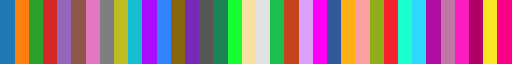

In [4]:
colors = pc.qualitative.D3 + pc.qualitative.Alphabet
discrete_cmap = mcolors.ListedColormap(colors)

print(discrete_cmap.N)
discrete_cmap

# Directories

In [5]:
MAIN_DIR = Path('.').resolve() / 'example_data' / 'GBM' 
DATA_DIR = MAIN_DIR / 'data'

In [6]:
GE_FNAME = DATA_DIR / 'gene_expression.csv'
METHY_FNAME = DATA_DIR / 'methy.csv'
MIRNA_FNAME = DATA_DIR / 'mirna.csv'
CLIN_FNAME = DATA_DIR / 'survival.csv'

In [7]:
RESULTS_DIR = MAIN_DIR / 'netflow_results'

if not RESULTS_DIR.is_dir():
    RESULTS_DIR.mkdir()

# Initialize the keeper

In [8]:
keeper = nf.Keeper(outdir=RESULTS_DIR)

In [9]:
for dl, f in zip(['RNA', 'methy', 'miRNA', 'survival'], [GE_FNAME, METHY_FNAME, MIRNA_FNAME, CLIN_FNAME]):
    keeper.load_data(f, label=dl, index_col=0)

# NetFlow pipeline

## Compute distances

We compute sample-pairwise Euclidean distances on each omic dataset:

In [10]:
for dd in ['RNA', 'methy', 'miRNA']:
    keeper.euc_distance_pairwise_observation_profile(dd)

## Compute similarities

In [11]:
n_neighbors = 12

for dd in keeper.distances:
    try:
        keeper.compute_similarity_from_distance(dd.label, n_neighbors, 'max',                                                    
                                                label=None, knn=False)
    except Exception as e:
        print(e, dd)

## Fuse similarities

In [12]:
keeper.similarities.keys()

dict_keys(['similarity_max12nn_RNA_profile_euc', 'similarity_max12nn_methy_profile_euc', 'similarity_max12nn_miRNA_profile_euc'])

In [13]:
n_neighbors = 12

# labels of similarties, as referenced in the Keeper, to fuse:
fs = [f'similarity_max{n_neighbors}nn_RNA_profile_euc', 
      f'similarity_max{n_neighbors}nn_methy_profile_euc', 
      f'similarity_max{n_neighbors}nn_miRNA_profile_euc']

# label to reference the fused similarity in the Keeper:
fsl = f"fused_similarity_max{n_neighbors}nn_RNA_methy_miRNA_euc"

# Fuse the similarities:
keeper.fuse_similarities(fs, fused_key=fsl)

## Compute diffusion distances from (fused) similarities

In [14]:
for sim_label in keeper.similarities.keys():
    # print(sim.label)
    keeper.compute_dpt_from_similarity(sim_label, density_normalize=True)

## Compute the POSE

We compute the POSE with respect to the diffusion distances for each individual modality as well as the fused multi-modal distances:

In [15]:
mutual = True
k_mnn = 1
min_branch_size = 10
root = 'density_inv'
root_as_tip = True
n_branches = 5

for key in keeper.distances.keys():
    if not key.startswith('dpt'):
        continue
    
    g_name = f'POSE_{k_mnn}mnn_{n_branches}branches_{key}'

    if g_name in keeper.graphs:
        continue

    poser, G_poser_nn = keeper.construct_pose(key, n_branches=n_branches, 
                                              min_branch_size=min_branch_size, # 10,
                                              until_branched=True, verbose='ERROR', 
                                              mutual=mutual, k_mnn=k_mnn,
                                              root=root, root_as_tip=root_as_tip)

    G_poser_nn.name = g_name  

    # if n_branches > 3:
    #     if max(dict(nx.get_node_attributes(G_poser_nn, 
    #                                        'branch')).values()) == max(dict(nx.get_node_attributes(keeper.graphs[g_name.replace(f"{n_branches}branches", "3branches")], 
    #                                                                                                'branch')).values()):
    #         print(f"no additional branches for {g_name}...")
    #         break

    try:                
        keeper.add_graph(G_poser_nn, G_poser_nn.name)
    except Exception as e:
        print(f"skipping {key} - {e}...")


netflow.pose.organization: 05/02/2025 02:57:53  PM | MSG | _logging:set_verbose:121 | >>> Logging verbosity set to 
40.

netflow.pose.organization: 05/02/2025 02:57:53  PM | MSG | _logging:set_verbose:121 | >>> Logging verbosity set to 
40.

netflow.pose.organization: 05/02/2025 02:57:53  PM | MSG | _logging:set_verbose:121 | >>> Logging verbosity set to 
40.

## Probing the POSE

### BL-clustering

In [26]:
for gg in keeper.graphs:
    if not gg.name.startswith('POSE'):
         continue

    nfc.louvain_paritioned(gg, 'branch', louvain_attr='louvain0x1', 
                           weight='inverted_distance', resolution=0.1, seed=0)

### Survival analysis

In [17]:
clin = keeper.data['survival'].to_frame().T

__Survival analysis based on backbone branches__

Kaplan-Meier Survival analysis (with logrank and multi-variate logrank p-values) shown for branches of POSEs for single-modality and fused-modality. We find that DNA methylation does have surivival information but the fused multi-omic POSE is the most descriptive in terms of survival profiles and identifies the largest lower-risk subtype.

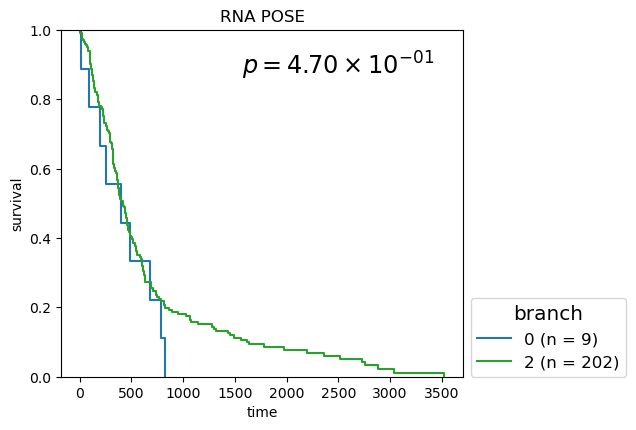

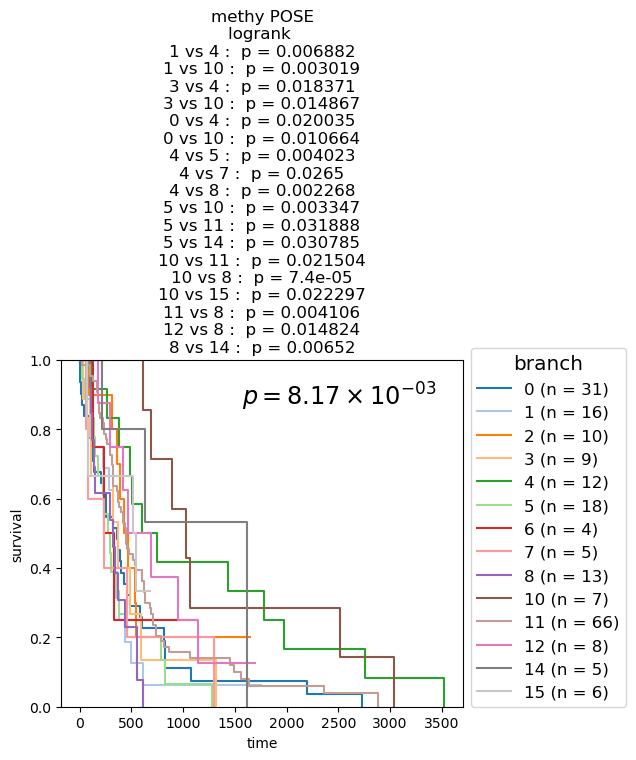

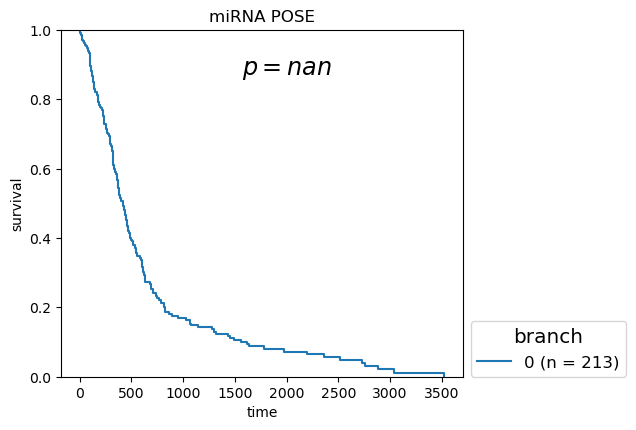

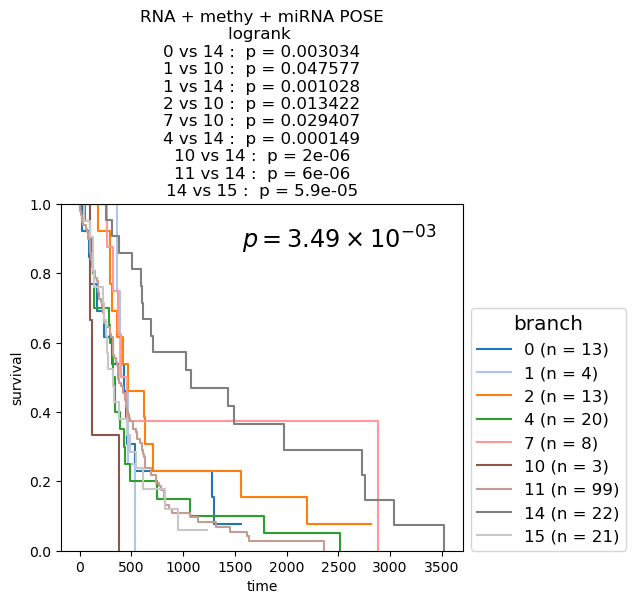

In [22]:
for g_name in keeper.graphs.keys():

    partition = pd.DataFrame({kk: dict(keeper.graphs[g_name].nodes.data(kk)) for kk in ['name', 'branch']}).set_index('name')['branch'] 

    if partition.nunique() <= 10:
        cmap = plt.cm.tab10
    elif partition.nunique() <= 20:
        cmap = plt.cm.tab20
    else:
        cmap = discrete_cmap

    fig, ax = plt.subplots(1,1, figsize=(6.,4.2))
    df = pd.concat([partition, clin], axis=1)
    nfv.KM_between_groups(df['Survival'], df['Death'], df[partition.name], min_group_size=3, 
                          ttl=g_name.split(f'max{n_neighbors}nn_')[-1].split('_euc')[0].split('_profile')[0].replace('_', ' + ') + ' POSE', # g_name.replace('from', '\nfrom').replace('max12nn', '\nmax12nn'),
                          precision=6,
                          colors=dict(zip(sorted(partition.unique()), cmap.colors)),
                          show_at_risk_counts=False, xlabel='time', ax=ax)
    ax.set_ylabel('survival');
    ax.set_ylim([0., 1]);
    p_mv = multivariate_logrank_test(df['Survival'], df[partition.name], event_observed=df['Death'])

    lrp = f"{p_mv.p_value:2.2e}"
    if 'e' in lrp:
        lrp = r"$p = {0} \times 10^{{{1}}}$".format(*lrp.split('e'))
    else:
        lrp = r"$p = {0}$".format(lrp)

    plt.gca().text(0.45, 0.85, lrp, transform=plt.gca().transAxes, ha='left', va='bottom', fontsize='xx-large');
    plt.gca().legend(fontsize='large', title=partition.name, title_fontsize='x-large', loc=(1.02, 0.))

__Survival analysis based on BL-clusters__

Kaplan-Meier Survival analysis (with logrank and multi-variate logrank p-values) shown for BL-clusters of POSEs for single-modality and fused-modality. We find that BL-clusters provide finer resolution and more informative clustering with respect to survival. Again, the fused multi-omic POSE is the most descriptive in terms of survival profiles and identifies the largest lower-risk subtype.

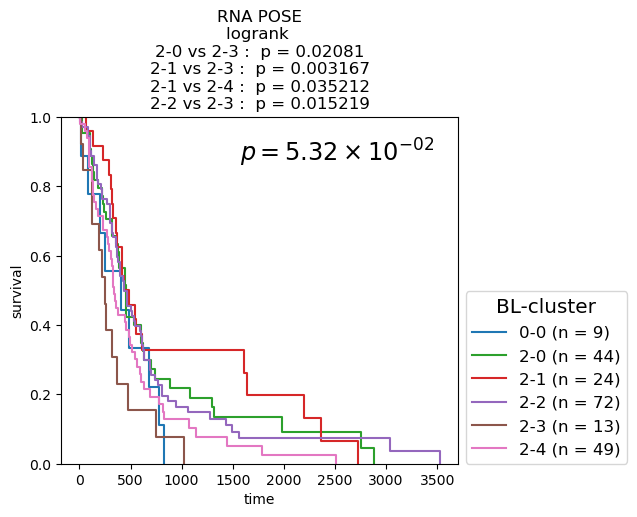

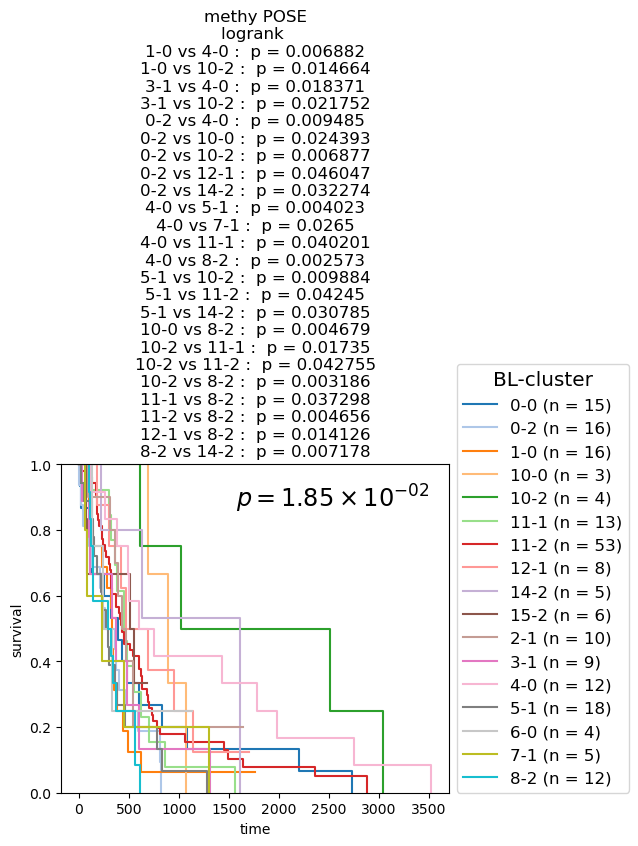

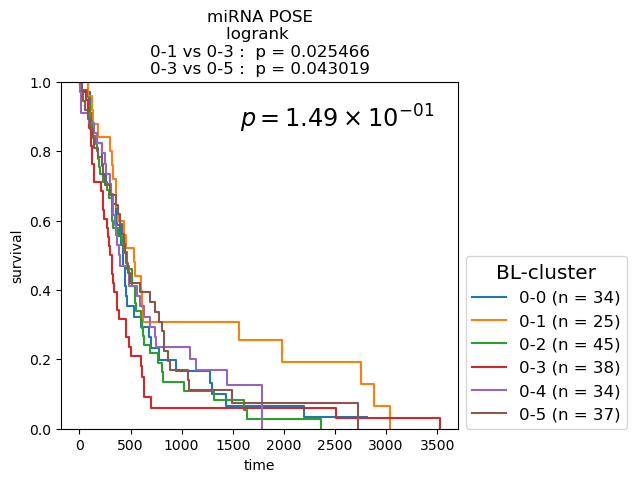

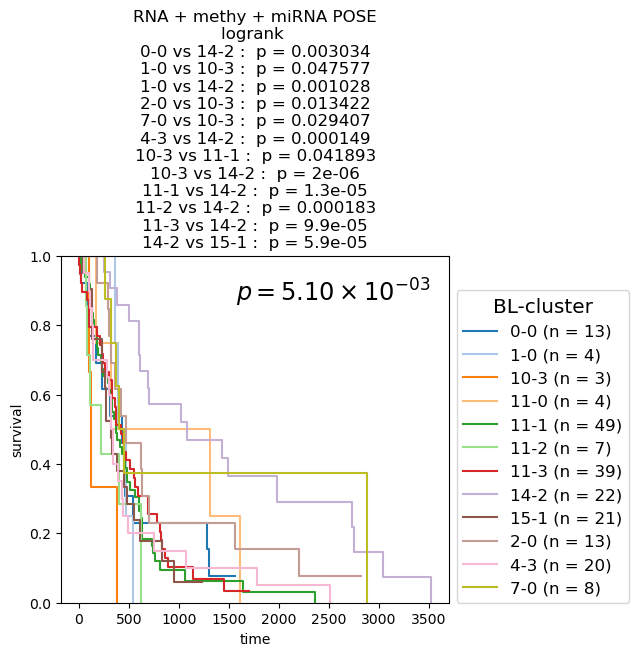

In [29]:
for g_name in keeper.graphs.keys():

    partition = pd.DataFrame({kk: dict(keeper.graphs[g_name].nodes.data(kk)) for kk in ['name', 'branch-louvain0x1']}).set_index('name')['branch-louvain0x1'] 

    if partition.nunique() <= 10:
        cmap = plt.cm.tab10
    elif partition.nunique() <= 20:
        cmap = plt.cm.tab20
    else:
        cmap = discrete_cmap

    fig, ax = plt.subplots(1,1, figsize=(6.,4.2))
    df = pd.concat([partition, clin], axis=1)
    nfv.KM_between_groups(df['Survival'], df['Death'], df[partition.name], min_group_size=3, 
                          ttl=g_name.split(f'max{n_neighbors}nn_')[-1].split('_euc')[0].split('_profile')[0].replace('_', ' + ') + ' POSE', # g_name.replace('from', '\nfrom').replace('max12nn', '\nmax12nn'),
                          precision=6,
                          colors=dict(zip(sorted(partition.unique()), cmap.colors)),
                          show_at_risk_counts=False, xlabel='time', ax=ax)
    ax.set_ylabel('survival');
    ax.set_ylim([0., 1]);
    p_mv = multivariate_logrank_test(df['Survival'], df[partition.name], event_observed=df['Death'])

    lrp = f"{p_mv.p_value:2.2e}"
    if 'e' in lrp:
        lrp = r"$p = {0} \times 10^{{{1}}}$".format(*lrp.split('e'))
    else:
        lrp = r"$p = {0}$".format(lrp)

    plt.gca().text(0.45, 0.85, lrp, transform=plt.gca().transAxes, ha='left', va='bottom', fontsize='xx-large');
    plt.gca().legend(fontsize='large', title='BL-cluster', title_fontsize='x-large', loc=(1.02, 0.))

### Interactive visualization

In [109]:
key = 'dpt_from_transitions_sym_fused_similarity_max12nn_RNA_methy_miRNA_euc_density_normalized'

pose_key = f"POSE_1mnn_5branches_{key}"

nf.render_pose(keeper, pose_key, key, port=1782)

Survival analysis between BL-cluster 14-2 (or equivalently, branch 14) and the rest of the cohort, reveals that BL-cluster 14-2 is a lower-risk GBM subtype:

22
191


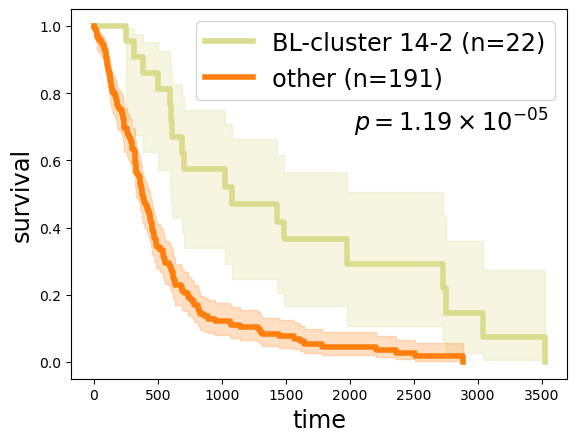

In [60]:
ll = 'TCGA-02-0084, TCGA-06-0146, TCGA-06-0221, TCGA-02-0258, TCGA-02-0116, TCGA-02-0069, TCGA-02-0104, TCGA-02-0080, TCGA-02-0010, TCGA-06-0129, TCGA-02-0114, TCGA-02-0074, TCGA-06-0128, TCGA-02-0058, TCGA-02-0432, TCGA-08-0344, TCGA-02-0087, TCGA-06-0686, TCGA-08-0516, TCGA-02-0007, TCGA-02-0028, TCGA-06-0178'

ll = ll.split(', ')

rr = list(set(clin.index) - set(ll))

print(len(ll))
print(len(rr))

fig, ax = plt.subplots(1, 1)
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf1.fit(clin.loc[ll, 'Survival'], event_observed=clin.loc[ll, 'Death'], label=f'BL-cluster 14-2 (n={len(ll)})')
kmf2.fit(clin.loc[rr, 'Survival'], event_observed=clin.loc[rr, 'Death'], label=f'other (n={len(rr)})')

lr = logrank_test(clin.loc[ll, 'Survival'], clin.loc[rr, 'Survival'], event_observed_A=clin.loc[ll, 'Death'], event_observed_B=clin.loc[rr, 'Death'])

# kmf1.plot(ax=ax, lw=4, color=plt.cm.tab20.colors[14])
kmf1.plot(ax=ax, lw=4, color=plt.cm.tab20.colors[17])
kmf2.plot(ax=ax, lw=4)
ax.set_xlabel('time', fontsize='xx-large');
ax.set_ylabel('survival', fontsize='xx-large');
ax.legend(loc='upper right', fontsize='xx-large');

lrp = f"{lr.p_value:2.2e}"
if 'e' in lrp:
    lrp = r"$p = {0} \times 10^{{{1}}}$".format(*lrp.split('e'))
else:
    lrp = r"$p = {0}$".format(lrp)
ax.text(0.57, 0.65, lrp, transform=ax.transAxes, ha='left', va='bottom', fontsize='xx-large');

### Panel visualization

To further investigate the fused POSE, we can look at side-by-side panels of the POSE color-coded by its clustering:

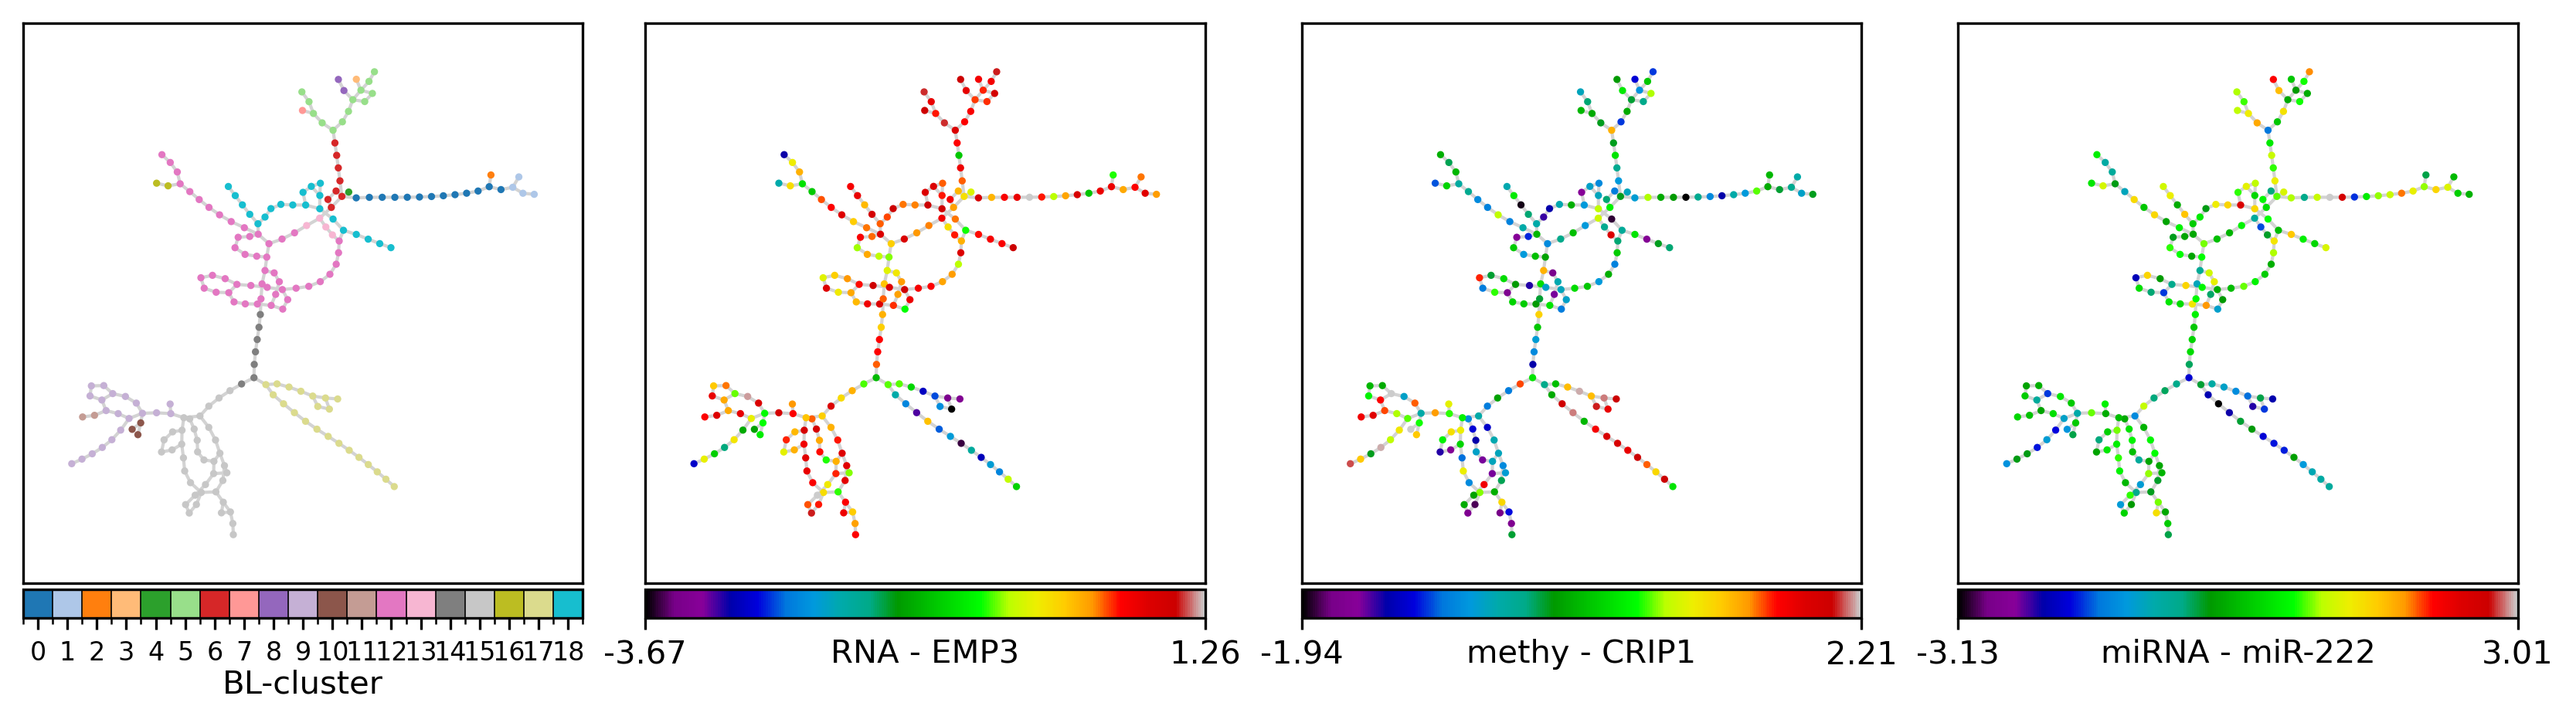

In [188]:
s = None

gls = {'RNA': ['EMP3', # 'HSPA6', 
               # 'TIMP1', # 'EFEMP2', 'FLJ11286', # 'PLA2G2A', 'MAPK8', 'ADM', 'CSRP1', 'KCNE4',
                          ],
       'methy': ['CRIP1_P274_F', #  'FES_P223_R', # 'IL17RB_E164_R', 'RAB32_E314_R', 'PAX6_P1121_F', # 'PYCARD_E87_F', 'HDAC1_P414_R', 'FRZB_P406_F', 'ISL1_P379_F', 'NR2F6_E375_R',
                ],
       'miRNA': ['hsa-miR-222', #  'hsa-miR-221', # 'hsa-miR-34a', 'hsa-miR-34b', 'hsa-miR-328', # 'hsa-miR-340', 'hsa-miR-17-3p', 'hsa-miR-197', 'hsa-miR-181d', 'hsa-miR-155',
                ],
      }

key = 'dpt_from_transitions_sym_fused_similarity_max12nn_RNA_methy_miRNA_euc_density_normalized'
g_name = f'POSE_1mnn_5branches_{key}'

G_poser_nn = keeper.graphs[g_name]
pos = nx.layout.kamada_kawai_layout(G_poser_nn)
nl = list(G_poser_nn)

if s is None:
    border_linewidths = 0
else:
    s_names = {G_poser_nn.nodes[k]['name']: k for k in G_poser_nn}
    s = set([s_names[k] for k in s])
    border_linewidths = [0.6 if k in s else 0. for k in nl] 
bordercolors = 'k'

bl = pd.Series(dict(nx.get_node_attributes(G_poser_nn, 'branch-louvain0x1')))
bl_code = dict(zip(bl.unique(), range(bl.nunique())))
record_colors = {# 'branch': [G_poser_nn.nodes[k]['branch'] for k in nl],
                 'BL-cluster': [bl_code[G_poser_nn.nodes[k]['branch-louvain0x1']] for k in nl],
                }

# clin_rr = clin.rename(index={G_poser_nn.nodes[k]['name']: k for k in G_poser_nn}, columns={'Survival': 'OS', 'Death': 'OS status'})
# clin_rr = {k: vl.loc[nl].values for k, vl in clin_rr.iteritems()}

rr = pd.concat([keeper.data[r].to_frame().loc[gl].T.rename(columns={k: ' - '.join([r, k]) for k in gl}) for r, gl in gls.items()], axis=1)
rr = rr.rename(index={G_poser_nn.nodes[k]['name']: k for k in G_poser_nn})
rr = {k: vl.loc[nl].values for k, vl in rr.iteritems()}

record_colors = {**record_colors, **rr} # {**record_colors, **clin_rr, **rr}


bl_ntm = {ss: s for s, ss in bl_code.items()}

                              
fig, axes = plt.subplots(1, 4, figsize=(11, 3), constrained_layout=True, dpi=300)

for (lbl, nc), ax in zip(record_colors.items(), np.ravel(axes)): 
    if lbl=='OS status': 
        ntm = {0: 'alive', 1: 'deceased'}
        c = 'tab10'
        node_cbar_ticks_kws = None
    elif lbl in ['branch', 'Louvain (0.1)']:
        if len(set(nc)) > 25:
            ntm = {kk: str(kk) if kk in [min(nc), max(nc)] else '' for kk in set(nc)}
            node_cbar_ticks_kws = None
        else:
            ntm = None
            node_cbar_ticks_kws = {'fontsize': 8}
        c = 'tab10' if len(set(nc)) <= 10 else 'tab20' if len(set(nc)) <= 20 else discrete_cmap 
        
    elif lbl == 'BL-cluster':
        if len(set(nc)) > 25: # 15:
            ntm = {kk: str(kk) if kk in [min(nc), max(nc)] else '' for kk in set(nc)} # {kk: bl_ntm[kk] if kk in [min(nc), max(nc)] else '' for kk in set(nc)}
            node_cbar_ticks_kws = None
        else:
            ntm = None # bl_ntm
            node_cbar_ticks_kws = {'fontsize': 8} # , 'rotation': 90} 
        c = 'tab10' if len(set(nc)) <= 10 else 'tab20' if len(set(nc)) <= 20 else discrete_cmap 
    else:
        ntm = None
        c = 'nipy_spectral'
        node_cbar_ticks_kws = None # {'fontsize': 8} # None
    
    nfv.plot_topology(G_poser_nn, pos=pos, nodelist=nl, ax=ax,
                      node_color=nc, node_shape='o', # ns,
                      node_cmap=c, node_cbar=True, node_size=5,
                      edge_color='lightgray', node_cbar_label=lbl.replace('_P274_F', '').replace('hsa-', ''), 
                      node_ticklabels_mapper=ntm, node_cbar_ticks_kws=node_cbar_ticks_kws,
                      border_linewidths=border_linewidths, bordercolors=bordercolors)  
    
# fig.savefig('GBM_pose.png', dpi=300, bbox_inches='tight', transparent=True)

And we can create the same figure, annotating the selected samples as follows:

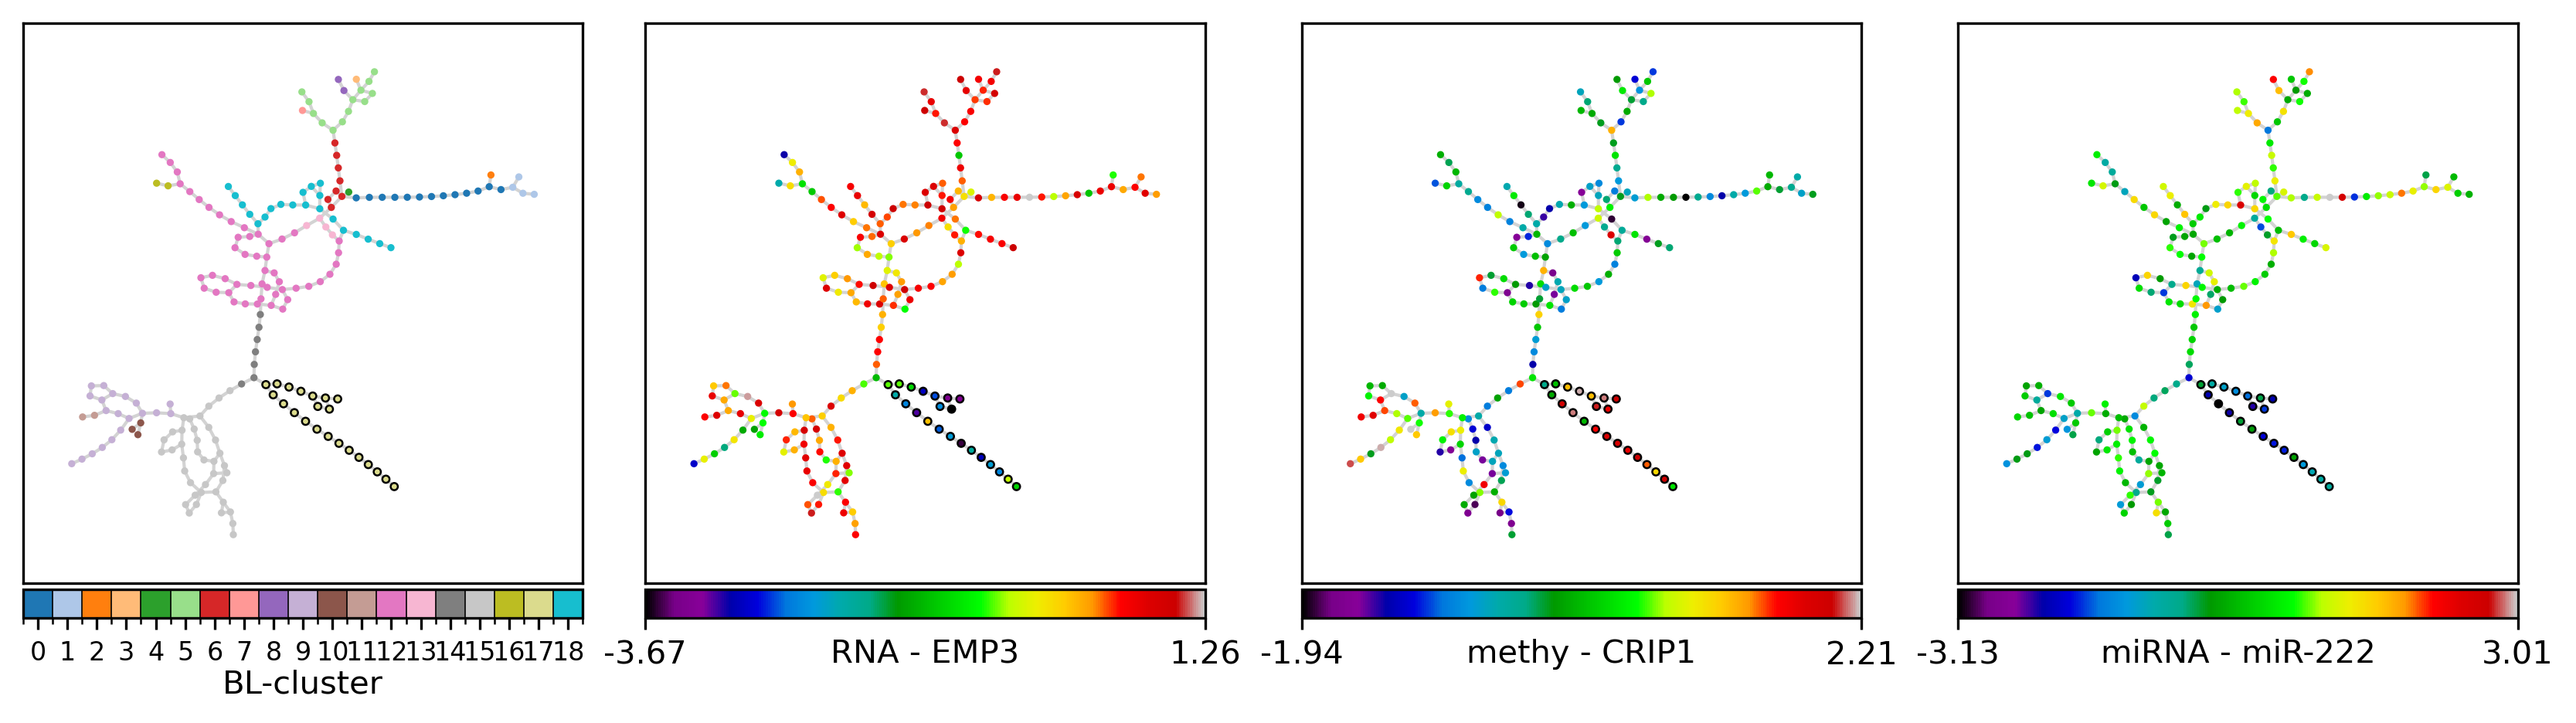

In [189]:
s = 'TCGA-02-0084, TCGA-06-0146, TCGA-06-0221, TCGA-02-0258, TCGA-02-0116, TCGA-02-0069, TCGA-02-0104, TCGA-02-0080, TCGA-02-0010, TCGA-06-0129, TCGA-02-0114, TCGA-02-0074, TCGA-06-0128, TCGA-02-0058, TCGA-02-0432, TCGA-08-0344, TCGA-02-0087, TCGA-06-0686, TCGA-08-0516, TCGA-02-0007, TCGA-02-0028, TCGA-06-0178'
s = s.split(', ')

gls = {'RNA': ['EMP3', # 'HSPA6', 
               # 'TIMP1', # 'EFEMP2', 'FLJ11286', # 'PLA2G2A', 'MAPK8', 'ADM', 'CSRP1', 'KCNE4',
                          ],
       'methy': ['CRIP1_P274_F', #  'FES_P223_R', # 'IL17RB_E164_R', 'RAB32_E314_R', 'PAX6_P1121_F', # 'PYCARD_E87_F', 'HDAC1_P414_R', 'FRZB_P406_F', 'ISL1_P379_F', 'NR2F6_E375_R',
                ],
       'miRNA': ['hsa-miR-222', #  'hsa-miR-221', # 'hsa-miR-34a', 'hsa-miR-34b', 'hsa-miR-328', # 'hsa-miR-340', 'hsa-miR-17-3p', 'hsa-miR-197', 'hsa-miR-181d', 'hsa-miR-155',
                ],
      }

key = 'dpt_from_transitions_sym_fused_similarity_max12nn_RNA_methy_miRNA_euc_density_normalized'
g_name = f'POSE_1mnn_5branches_{key}'

G_poser_nn = keeper.graphs[g_name]
pos = nx.layout.kamada_kawai_layout(G_poser_nn)
nl = list(G_poser_nn)

if s is None:
    border_linewidths = 0
else:
    s_names = {G_poser_nn.nodes[k]['name']: k for k in G_poser_nn}
    s = set([s_names[k] for k in s])
    border_linewidths = [0.6 if k in s else 0. for k in nl] 
bordercolors = 'k'

bl = pd.Series(dict(nx.get_node_attributes(G_poser_nn, 'branch-louvain0x1')))
bl_code = dict(zip(bl.unique(), range(bl.nunique())))
record_colors = {# 'branch': [G_poser_nn.nodes[k]['branch'] for k in nl],
                 'BL-cluster': [bl_code[G_poser_nn.nodes[k]['branch-louvain0x1']] for k in nl],
                }

# clin_rr = clin.rename(index={G_poser_nn.nodes[k]['name']: k for k in G_poser_nn}, columns={'Survival': 'OS', 'Death': 'OS status'})
# clin_rr = {k: vl.loc[nl].values for k, vl in clin_rr.iteritems()}

rr = pd.concat([keeper.data[r].to_frame().loc[gl].T.rename(columns={k: ' - '.join([r, k]) for k in gl}) for r, gl in gls.items()], axis=1)
rr = rr.rename(index={G_poser_nn.nodes[k]['name']: k for k in G_poser_nn})
rr = {k: vl.loc[nl].values for k, vl in rr.iteritems()}

record_colors = {**record_colors, **rr} # {**record_colors, **clin_rr, **rr}

bl_ntm = {ss: s for s, ss in bl_code.items()}

                              
fig, axes = plt.subplots(1, 4, figsize=(11, 3), constrained_layout=True, dpi=300)

for (lbl, nc), ax in zip(record_colors.items(), np.ravel(axes)): 
    if lbl=='OS status': 
        ntm = {0: 'alive', 1: 'deceased'}
        c = 'tab10'
        node_cbar_ticks_kws = None
    elif lbl in ['branch', 'Louvain (0.1)']:
        if len(set(nc)) > 25:
            ntm = {kk: str(kk) if kk in [min(nc), max(nc)] else '' for kk in set(nc)}
            node_cbar_ticks_kws = None
        else:
            ntm = None
            node_cbar_ticks_kws = {'fontsize': 8}
        c = 'tab10' if len(set(nc)) <= 10 else 'tab20' if len(set(nc)) <= 20 else discrete_cmap 
        
    elif lbl == 'BL-cluster':
        if len(set(nc)) > 25: # 15:
            ntm = {kk: str(kk) if kk in [min(nc), max(nc)] else '' for kk in set(nc)} # {kk: bl_ntm[kk] if kk in [min(nc), max(nc)] else '' for kk in set(nc)}
            node_cbar_ticks_kws = None
        else:
            ntm = None # bl_ntm
            node_cbar_ticks_kws = {'fontsize': 8} # , 'rotation': 90} 
        c = 'tab10' if len(set(nc)) <= 10 else 'tab20' if len(set(nc)) <= 20 else discrete_cmap 
    else:
        ntm = None
        c = 'nipy_spectral'
        node_cbar_ticks_kws = None # {'fontsize': 8} # None
    
    nfv.plot_topology(G_poser_nn, pos=pos, nodelist=nl, ax=ax,
                      node_color=nc, node_shape='o', # ns,
                      node_cmap=c, node_cbar=True, node_size=5,
                      edge_color='lightgray', node_cbar_label=lbl.replace('_P274_F', '').replace('hsa-', ''), 
                      node_ticklabels_mapper=ntm, node_cbar_ticks_kws=node_cbar_ticks_kws,
                      border_linewidths=border_linewidths, bordercolors=bordercolors)  
    
# fig.savefig('GBM_pose_selected.png', dpi=300, bbox_inches='tight', transparent=True)

as well as characteristic features significantly associated with the identifed lower-risk subtype:

In [118]:
ll = 'TCGA-02-0084, TCGA-06-0146, TCGA-06-0221, TCGA-02-0258, TCGA-02-0116, TCGA-02-0069, TCGA-02-0104, TCGA-02-0080, TCGA-02-0010, TCGA-06-0129, TCGA-02-0114, TCGA-02-0074, TCGA-06-0128, TCGA-02-0058, TCGA-02-0432, TCGA-08-0344, TCGA-02-0087, TCGA-06-0686, TCGA-08-0516, TCGA-02-0007, TCGA-02-0028, TCGA-06-0178'

ll = ll.split(', ')

bl_mapped = bl.map(bl_code)
bl_mapped = bl_mapped.rename(index=dict(nx.get_node_attributes(G_poser_nn, 'name')))
# display(bl_mapped.value_counts())

bl_mapped.loc[ll]

TCGA-02-0084    17
TCGA-06-0146    17
TCGA-06-0221    17
TCGA-02-0258    17
TCGA-02-0116    17
TCGA-02-0069    17
TCGA-02-0104    17
TCGA-02-0080    17
TCGA-02-0010    17
TCGA-06-0129    17
TCGA-02-0114    17
TCGA-02-0074    17
TCGA-06-0128    17
TCGA-02-0058    17
TCGA-02-0432    17
TCGA-08-0344    17
TCGA-02-0087    17
TCGA-06-0686    17
TCGA-08-0516    17
TCGA-02-0007    17
TCGA-02-0028    17
TCGA-06-0178    17
dtype: int64

22
191


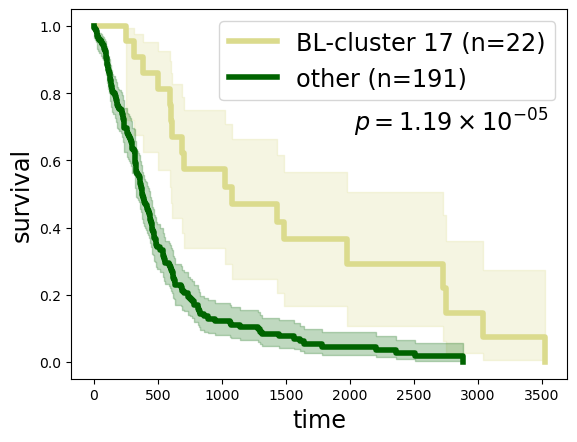

In [123]:
ll = 'TCGA-02-0084, TCGA-06-0146, TCGA-06-0221, TCGA-02-0258, TCGA-02-0116, TCGA-02-0069, TCGA-02-0104, TCGA-02-0080, TCGA-02-0010, TCGA-06-0129, TCGA-02-0114, TCGA-02-0074, TCGA-06-0128, TCGA-02-0058, TCGA-02-0432, TCGA-08-0344, TCGA-02-0087, TCGA-06-0686, TCGA-08-0516, TCGA-02-0007, TCGA-02-0028, TCGA-06-0178'

ll = ll.split(', ')

rr = list(set(clin.index) - set(ll))

print(len(ll))
print(len(rr))

fig, ax = plt.subplots(1, 1)
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
# kmf1.fit(clin.loc[ll, 'Survival'], event_observed=clin.loc[ll, 'Death'], label=f'BL-cluster 14-2 (n={len(ll)})')
kmf1.fit(clin.loc[ll, 'Survival'], event_observed=clin.loc[ll, 'Death'], label=f'BL-cluster 17 (n={len(ll)})')
kmf2.fit(clin.loc[rr, 'Survival'], event_observed=clin.loc[rr, 'Death'], label=f'other (n={len(rr)})')

lr = logrank_test(clin.loc[ll, 'Survival'], clin.loc[rr, 'Survival'], event_observed_A=clin.loc[ll, 'Death'], event_observed_B=clin.loc[rr, 'Death'])

# kmf1.plot(ax=ax, lw=4, color=plt.cm.tab20.colors[14])
kmf1.plot(ax=ax, lw=4, color=plt.cm.tab20.colors[17])
kmf2.plot(ax=ax, lw=4, color='darkgreen')
ax.set_xlabel('time', fontsize='xx-large');
ax.set_ylabel('survival', fontsize='xx-large');
ax.legend(loc='upper right', fontsize='xx-large');

lrp = f"{lr.p_value:2.2e}"
if 'e' in lrp:
    lrp = r"$p = {0} \times 10^{{{1}}}$".format(*lrp.split('e'))
else:
    lrp = r"$p = {0}$".format(lrp)
ax.text(0.57, 0.65, lrp, transform=ax.transAxes, ha='left', va='bottom', fontsize='xx-large');


# fig.savefig('GBM_BLcluster17_KM.png', dpi=300, bbox_inches='tight', transparent=True)


### Inspect modality proportion of influence

In [79]:
refs = {'RNA': 'transitions_sym_similarity_max12nn_RNA_profile_euc_density_normalized',
        'methy': 'transitions_sym_similarity_max12nn_methy_profile_euc_density_normalized',
        'miRNA': 'transitions_sym_similarity_max12nn_miRNA_profile_euc_density_normalized',
        'fused': 'transitions_sym_fused_similarity_max12nn_RNA_methy_miRNA_euc_density_normalized',
       }

In [89]:
edge_attr = {v: {modality: keeper.misc[P][v] for modality, P in refs.items()} for v in G_poser_nn.edges()}

In [105]:
edge_attr_proportions = {}
for v, attr in edge_attr.items():
    mn = sum([attr[k] for k in ['RNA', 'methy', 'miRNA']])
    edge_attr_proportions[v] = {'_'.join([k, 'proportion']) : attr[k] / mn for k in ['RNA', 'methy', 'miRNA']}

In [108]:
nx.set_edge_attributes(G_poser_nn, edge_attr_proportions)

#### visualization

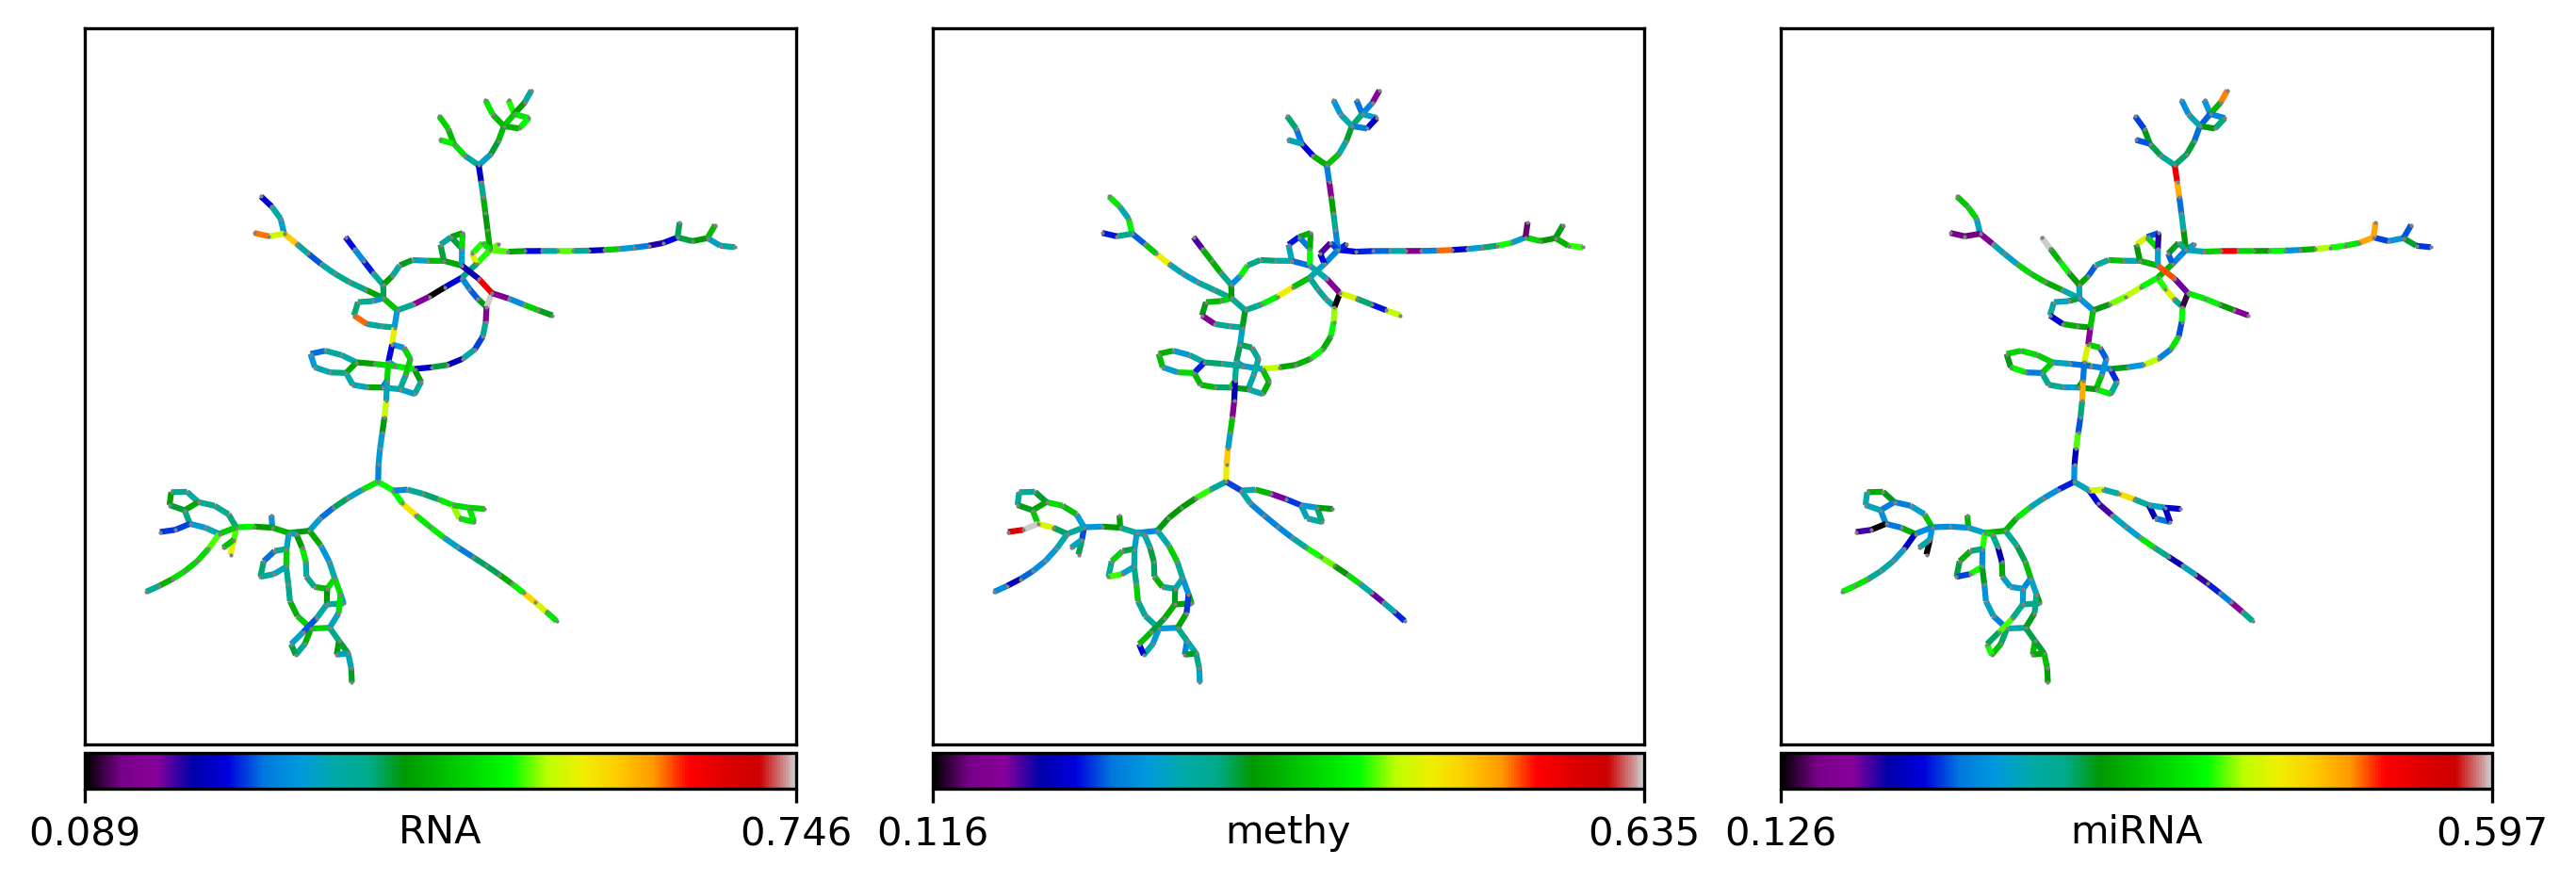

In [151]:
s = None

gls = {'RNA': ['EMP3', # 'HSPA6', 
               # 'TIMP1', # 'EFEMP2', 'FLJ11286', # 'PLA2G2A', 'MAPK8', 'ADM', 'CSRP1', 'KCNE4',
                          ],
       'methy': ['CRIP1_P274_F', #  'FES_P223_R', # 'IL17RB_E164_R', 'RAB32_E314_R', 'PAX6_P1121_F', # 'PYCARD_E87_F', 'HDAC1_P414_R', 'FRZB_P406_F', 'ISL1_P379_F', 'NR2F6_E375_R',
                ],
       'miRNA': ['hsa-miR-222', #  'hsa-miR-221', # 'hsa-miR-34a', 'hsa-miR-34b', 'hsa-miR-328', # 'hsa-miR-340', 'hsa-miR-17-3p', 'hsa-miR-197', 'hsa-miR-181d', 'hsa-miR-155',
                ],
      }

key = 'dpt_from_transitions_sym_fused_similarity_max12nn_RNA_methy_miRNA_euc_density_normalized'
g_name = f'POSE_1mnn_5branches_{key}'

G_poser_nn = keeper.graphs[g_name]
pos = nx.layout.kamada_kawai_layout(G_poser_nn)
nl = list(G_poser_nn)
el = list(G_poser_nn.edges())

ee = pd.DataFrame({k: dict(nx.get_edge_attributes(G_poser_nn, '_'.join([k, 'proportion']))) for k in ['RNA', 'methy', 'miRNA']})
ee = ee.loc[el]


if s is None:
    border_linewidths = 0
else:
    s_names = {G_poser_nn.nodes[k]['name']: k for k in G_poser_nn}
    s = set([s_names[k] for k in s])
    border_linewidths = [0.6 if k in s else 0. for k in nl] 
bordercolors = 'k'


                              
# fig, axes = plt.subplots(1, 4, figsize=(11, 3), constrained_layout=True, dpi=300)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True, dpi=300)

ntm = None
c = plt.cm.nipy_spectral
node_cbar_ticks_kws = None


for (lbl, ec), ax in zip(ee.iteritems(), np.ravel(axes)): 

    
    nfv.plot_topology(G_poser_nn, pos=pos, nodelist=nl, ax=ax,
                      node_color='gray', node_shape='o', # ns,
                      edge_cmap=c, edge_cbar=True, node_size=1,
                      edge_width=1.5,
                      edge_color=ec.values, edge_cbar_label=lbl, 
                      # node_ticklabels_mapper=ntm, node_cbar_ticks_kws=node_cbar_ticks_kws,
                      border_linewidths=border_linewidths, bordercolors=bordercolors,
                      edge_cbar_kws={'location': 'bottom', 'orientation': 'horizontal', 'pad': 0.01}
                     )  
    
# fig.savefig('Downloads/GBM_pose_edges.png', 
#             dpi=300, bbox_inches='tight', transparent=True)

# References

[1] Wang, B., Mezlini, A.M., Demir, F., Fiume, M., Tu, Z., Brudno, M., Haibe-Kains, B. and Goldenberg, A., 2014. Similarity network fusion for aggregating data types on a genomic scale. Nature methods, 11(3), pp.333-337. https://www.nature.com/articles/nmeth.2810